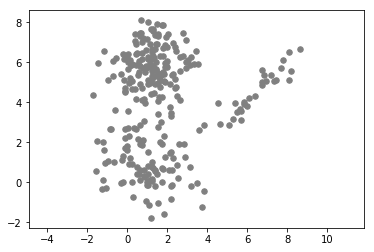

In [4]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from grader import Grader
import scipy

%matplotlib inline

samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

In [40]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    
    pi = np.zeros(C)
    mu = np.zeros((C, d))
    sigma = np.zeros((C, d, d))

    for k in range(C):
        n_k = gamma[:,k].sum()
        mu[k,:] = np.sum(X  * gamma[:,k][:,np.newaxis], axis=0) / n_k
        sigma[k,:] = np.sum([gamma[i,k] * np.outer(X[i] - mu[k], X[i] - mu[k]) for i in range(N)], axis=0) / n_k
        pi[k] = n_k / float(N)

    return pi, mu, sigma

In [58]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object
    
    tmp_1 = np.zeros((N, C))
    for k in range(C):
        dist = scipy.stats.multivariate_normal(mu[k], sigma[k], allow_singular=True)
        tmp_1[:, k] = gamma[:, k] * dist.pdf(X)
        
    loss = np.sum(np.log(tmp_1.sum(axis=1)))

    return loss

In [66]:
def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)
    likelihoods = np.zeros((N, C))
    
    max_x = X.max()

    for i in range(C):
        dist = scipy.stats.multivariate_normal(mu[i], sigma[i], allow_singular=True)
        scaled_likelihoods = np.exp(dist.logpdf(X) - max_x)
        likelihoods[:,i] = pi[i] * scaled_likelihoods
    
    totals = np.sum(likelihoods, axis=1)

    gamma = likelihoods / totals[:, np.newaxis]        
    
    return gamma



In [79]:
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10, verbose=False):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters    
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None

    for restart in range(restarts):
        try:
            prev_loss = None
            pi = np.random.rand(C)
            mu = np.random.rand(C, d)
            sigma_ = np.random.rand(C, d, d)
            sigma = [np.dot(A, A.T) for A in sigma_]
            
            if verbose:
                print("Restarting : {}".format(restart))
            
            for _i in range(max_iter):
                gamma = E_step(X_, pi, mu, sigma)
                pi, mu, sigma = M_step(X_, gamma)
                loss = compute_vlb(X_, pi, mu, sigma, gamma)
                if verbose:
                    print("Iteration {}, loss: {}".format(_i, loss))

                if prev_loss is not None:
                    diff = np.abs(loss - prev_loss)
                    if diff < rtol:
                        break
                prev_loss = loss
            
            if verbose:
                print("Found best loss on iteration: {} -> {}".format(_i, loss))
            if best_loss is None or loss > best_loss:
                best_loss = loss
                best_mu = mu
                best_pi = pi
                best_sigma = sigma

        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass
        except ValueError:
            print("Nan in matrix")

    return best_loss, best_pi, best_mu, best_sigma

In [80]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X[:10], 3)
print(best_loss, best_pi, best_mu, best_sigma)

-809.918476465 [ 0.10730167  0.5507523   0.34194603] [[ 6.29646587  4.43105295]
 [ 1.2231453   5.83049424]
 [ 0.92118286  0.96714887]] [[[ 1.70836172  1.39128331]
  [ 1.39128331  1.32262578]]

 [[ 0.94344286  0.06726247]
  [ 0.06726247  1.10581387]]

 [[ 1.49900199 -0.37289283]
  [-0.37289283  1.43002783]]]


In [65]:
pi, mu, sigma = pi0, mu0, sigma0
prev_loss = None

X_ = X

for i in range(30):
    # plot_data_multi_vals(X, pi, mu, sigma)

    gamma = E_step(X_, pi, mu, sigma)
#    print(gamma.min())
#    print(pi)
    pi, mu, sigma = M_step(X_, gamma)
    loss = compute_vlb(X_, pi, mu, sigma, gamma)
    print("loss", loss)
    print(pi)
    if prev_loss is not None:
        print(loss - prev_loss)
    prev_loss = loss
    print()

AttributeError: module 'numpy' has no attribute 'exop'

In [30]:
np.log(0)

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [21]:
0. * np.log(0)

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan